# ML Task - Predicting LOS using window and PySpark

Start with the necessary imports...

In [23]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import lag, col, avg, hour, dayofweek, dayofmonth, month, year
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit


import matplotlib.pyplot as plt
import pandas as pd


import os

Define necessary PySpark env variables.

In [2]:
#os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-21-openjdk-21.0.3.0.9-1.fc40.x86_64/'
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'
os.environ['SPARK_MASTER_HOST'] = 'localhost'

Building the spark session...

In [3]:
spark = SparkSession.builder \
    .appName("Setup") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.host","127.0.0.1") \
    .config("spark.driver.bindAddress","127.0.0.1") \
    .getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/19 15:33:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/19 15:33:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Read the previously processed data.

In [4]:
file_path = "dataset/DS.parquet"

ds = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

ds.printSchema()
ds.show(5)

root
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- LOS: double (nullable = true)
 |-- SEQ_NUM: integer (nullable = true)
 |-- TOTAL_EVENTS: long (nullable = true)
 |-- AGE_AT_ADMISSION: integer (nullable = true)
 |-- ADMITTIME: timestamp (nullable = true)
 |-- GENDER: double (nullable = true)
 |-- ADMISSION_TYPE: double (nullable = true)
 |-- MULTIPLE_ADMISSIONS: integer (nullable = true)
 |-- MULTIPLE_ICU_STAYS: integer (nullable = true)

+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|SUBJECT_ID|HADM_ID|   LOS|SEQ_NUM|TOTAL_EVENTS|AGE_AT_ADMISSION|          ADMITTIME|GENDER|ADMISSION_TYPE|MULTIPLE_ADMISSIONS|MULTIPLE_ICU_STAYS|
+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|       295| 192988|0.9057|      2|        1246|              61|2176-03-

## Window

Lets define a window, and we´ll order the window by admission time.

In [5]:
window_spec = Window.partitionBy('HADM_ID').orderBy(col('ADMITTIME'))

We'll use the lag function to look at previous records of LOS, as this can potentially provide some context.

In [6]:
#ds = ds.withColumn("LOS_PAST_2",lag("LOS",2).over(window_spec))
#ds = ds.withColumn("DIFF_LOS",col('LOS') - lag('LOS', 1).over(window_spec))
ds.show(5)

+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|SUBJECT_ID|HADM_ID|   LOS|SEQ_NUM|TOTAL_EVENTS|AGE_AT_ADMISSION|          ADMITTIME|GENDER|ADMISSION_TYPE|MULTIPLE_ADMISSIONS|MULTIPLE_ICU_STAYS|
+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|       295| 192988|0.9057|      2|        1246|              61|2176-03-06 12:30:00|   1.0|           1.0|                  0|                 0|
|      2791| 160235|1.3653|      4|         732|              74|2120-04-25 17:04:00|   1.0|           0.0|                  1|                 1|
|      2556| 135423| 0.705|      9|         736|              62|2173-02-20 23:57:00|   0.0|           0.0|                  0|                 0|
|      4496| 144907|1.4628|      5|        1446|              69|2165-09-23 13:59:00|   0.0|           0.0|           

In [7]:
ds.describe().show()

24/06/19 15:33:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+
|summary|       SUBJECT_ID|           HADM_ID|              LOS|          SEQ_NUM|      TOTAL_EVENTS|  AGE_AT_ADMISSION|           GENDER|     ADMISSION_TYPE|MULTIPLE_ADMISSIONS| MULTIPLE_ICU_STAYS|
+-------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-------------------+-------------------+-------------------+
|  count|            19903|             19903|            19903|            19903|             19903|             19903|            19903|              19903|              19903|              19903|
|   mean| 38183.9454353615|149955.19474451087|3.809590669748298|8.510023614530473| 5811.477616439733| 66.74013967743556| 0.43420589860825|0.23594433000050244| 0.1372154951514847|0.17811385218308798|
| std

# Models

In [8]:
features = ["TOTAL_EVENTS", "AGE_AT_ADMISSION", "GENDER", "ADMISSION_TYPE", "MULTIPLE_ADMISSIONS", "MULTIPLE_ICU_STAYS", "SEQ_NUM"]
target = "LOS"

In [9]:
(train_data, test_data) = ds.randomSplit([0.8, 0.2], seed=42)

assembler = VectorAssembler(inputCols=features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

## Linear regression

In [29]:
lr = LinearRegression(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(lr.maxIter, [10, 100, 1000]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
lr_model = tvs.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(5)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse}")

coefficients = lr_model.bestModel.coefficients
intercept = lr_model.bestModel.intercept

print("Coefficients: {}".format(coefficients))
print("Intercept: {:.2f}".format(intercept))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

+--------------------+------+------------------+
|            features|   LOS|        prediction|
+--------------------+------+------------------+
|[4941.0,39.0,1.0,...| 3.666|3.4373659967555206|
|(7,[0,1,6],[1312....|1.1862| 1.780430838687888|
|(7,[0,1,6],[3840....|3.5466| 2.702469599522108|
|[4732.0,72.0,0.0,...|4.3483|3.3888625911031074|
|(7,[0,1,6],[1407....|1.6412|2.0596082175940427|
+--------------------+------+------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 3.4617684259761567
R-squared on test data = 0.6173495804512128
Mean Absolute Error (MAE) on test data = 1.6510291472625784
Mean Squared Error (MSE) on test data = 11.98384063508544
Coefficients: [0.0003320377305882403,-0.012691262814855619,0.1281888623735033,0.1329539380133844,2.40886658949903,-2.639447961935132,0.13310408994539705]
Intercept: 1.63
Feature Importance:
  MULTIPLE_ICU_STAYS: 2.639
  MULTIPLE_ADMISSIONS: 2.409
  SEQ_NUM: 0.133
  ADMISSION_TYPE: 0.133
  GENDER: 0.128
  A

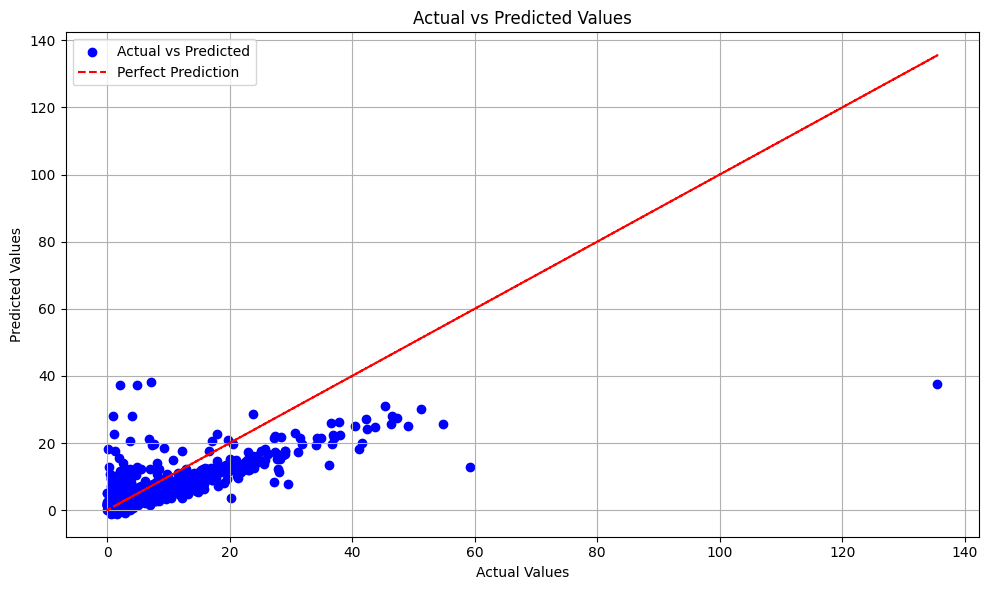

In [13]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Decision Tree Regressor

In [35]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 30])\
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=dt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
dt_model = tvs.fit(train_data)

predictions = dt_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(20)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse}")

coefficients = dt_model.bestModel.featureImportances

print("Coefficients: {}".format(coefficients))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

+--------------------+-------+------------------+
|            features|    LOS|        prediction|
+--------------------+-------+------------------+
|[4941.0,39.0,1.0,...|  3.666|3.8589914669223395|
|(7,[0,1,6],[1312....| 1.1862|1.2791054556726593|
|(7,[0,1,6],[3840....| 3.5466|  3.21241143946616|
|[4732.0,72.0,0.0,...| 4.3483|3.8589914669223395|
|(7,[0,1,6],[1407....| 1.6412|1.2791054556726593|
|[2690.0,76.0,1.0,...| 1.2469|2.3586364468864462|
|[3108.0,60.0,1.0,...| 3.0237|2.3586364468864462|
|[12627.0,75.0,1.0...|  7.128|  7.36906282722513|
|(7,[0,1,6],[5825....| 2.7712|3.8589914669223395|
|[2386.0,55.0,1.0,...|  2.036|1.7745364587089827|
|[21649.0,78.0,1.0...|15.2614|12.380274936708856|
|[1806.0,54.0,0.0,...| 2.0859|1.7745364587089827|
|[2061.0,44.0,0.0,...| 2.0667|1.7745364587089827|
|(7,[0,1,6],[3671....| 2.7446| 2.773943116634801|
|[18940.0,71.0,1.0...|12.8558|12.380274936708856|
|(7,[0,1,6],[2581....| 2.0323|2.3586364468864462|
|[1942.0,56.0,1.0,...| 1.3305|1.3474647639956097|


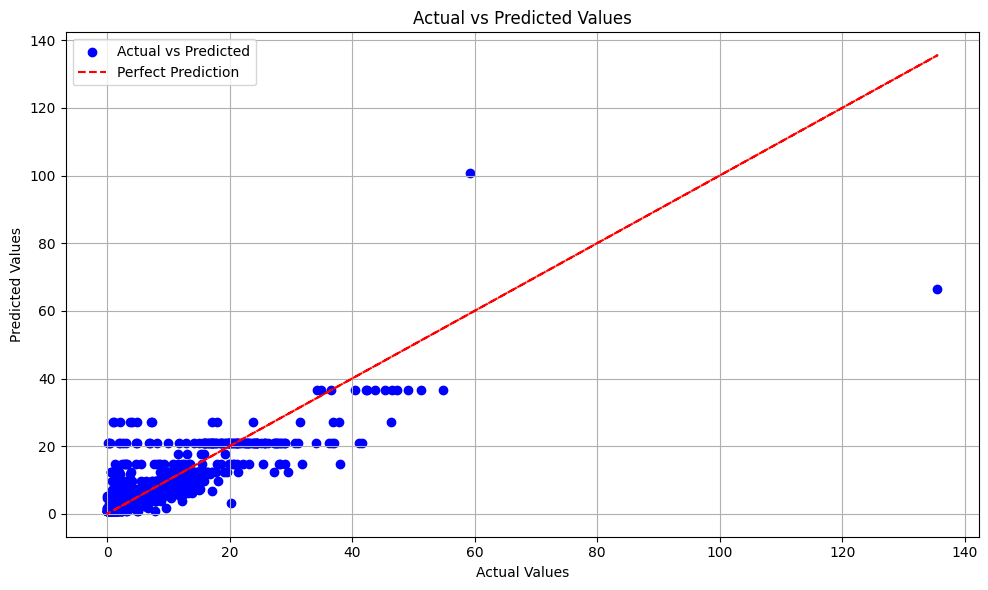

In [19]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Gradient-Boosted Trees Regressor (GBT)

In [32]:
gbt = GBTRegressor(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxBins, [20, 30])\
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
gbt_model = tvs.fit(train_data)

predictions = gbt_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(20)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2}")

evaluator.setMetricName("mae")
mae = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae}")

evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse}")

coefficients = gbt_model.bestModel.featureImportances

print("Coefficients: {}".format(coefficients))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB
24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1041.9 KiB
24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1033.0 KiB
24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1033.4 KiB
24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1034.2 KiB
24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1034.9 KiB
24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1036.7 KiB
24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1039.6 KiB
24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1044.1 KiB
24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1052.0 KiB
24/06/19 16:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1065.2 KiB
24/06/19 16:40:21 WAR

+--------------------+-------+------------------+
|            features|    LOS|        prediction|
+--------------------+-------+------------------+
|[4941.0,39.0,1.0,...|  3.666| 4.147971437189388|
|(7,[0,1,6],[1312....| 1.1862|1.2182457914978184|
|(7,[0,1,6],[3840....| 3.5466|3.1803239549879754|
|[4732.0,72.0,0.0,...| 4.3483| 3.898682225427288|
|(7,[0,1,6],[1407....| 1.6412| 1.271065003305674|
|[2690.0,76.0,1.0,...| 1.2469|2.3168049874862007|
|[3108.0,60.0,1.0,...| 3.0237| 2.438161534032084|
|[12627.0,75.0,1.0...|  7.128| 7.651277035278909|
|(7,[0,1,6],[5825....| 2.7712|3.9422349901300016|
|[2386.0,55.0,1.0,...|  2.036| 1.671001862372014|
|[21649.0,78.0,1.0...|15.2614|12.680969181281634|
|[1806.0,54.0,0.0,...| 2.0859|1.9017087052558386|
|[2061.0,44.0,0.0,...| 2.0667|2.0558001470355407|
|(7,[0,1,6],[3671....| 2.7446|2.8191829028434765|
|[18940.0,71.0,1.0...|12.8558|14.447616048016542|
|(7,[0,1,6],[2581....| 2.0323|2.3237617877396857|
|[1942.0,56.0,1.0,...| 1.3305|1.4123569777291567|


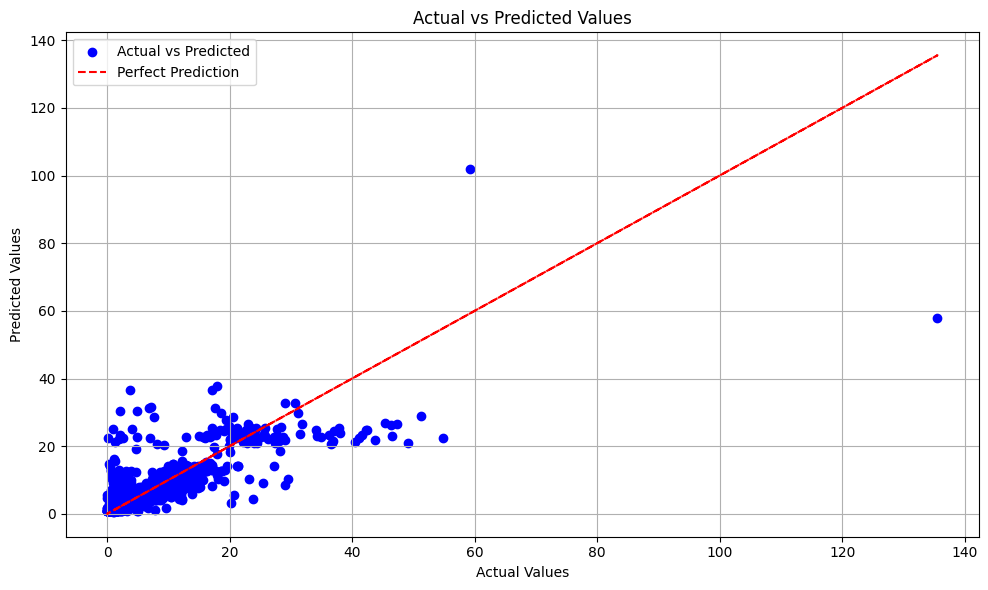

In [25]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()